In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
egfd=pd.read_csv('final_working_data.csv')
egfd.drop('Unnamed: 0',axis=1,inplace=True)
egfd.head()

,api,reported_fluid_type,lease_name,well_num,6mo_oil_x,6mo_time,1_mo_oil,1_mo_gas,2_mo_oil,2_mo_gas,...,btm_lat,btm_long,total_prop,total_fluid_pumped,stages_2,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil
0,42255328990000,O,METZ RANCH UNIT A,1,75763,6,4482,4949,10880,11175,...,29.046511,-97.740030,6412000,85904,1.0,1104.194556,5357.892850,967.904791,77520,268640
1,42255329040000,O,METZ RANCH UNIT A,2,64350,6,15547,18723,9629,13652,...,29.049162,-97.740164,6326000,90268,1.0,1204.283785,4594.270346,967.904791,77520,268640
2,42255355160000,O,METZ RANCH UNIT A,4,120351,6,9980,6480,20125,14097,...,29.069781,-97.736000,22240000,457437,1.0,649.298597,7198.096133,81.229467,77520,268640
3,42255358880100,O,METZ RANCH UNIT A,6,149589,6,4925,4372,38742,31201,...,29.062969,-97.750458,17674000,352397,1.0,887.715736,6727.843014,664.009203,77520,268640
4,42255358890000,O,METZ RANCH UNIT A,7,110928,6,2565,2752,27072,34553,...,29.064789,-97.750408,21154000,427006,1.0,1072.904483,7157.680515,18.262071,77520,268640


I'm going to do some quick column renaming to make it look a bit nicer. I'm also going to drop Stages_2 as I've identified that stage count is innacurately reported. This is from a previous EDA notebook.

In [3]:
egfd.drop('stages_2',axis=1,inplace=True)
egfd.columns

Index(['api', 'reported_fluid_type', 'lease_name', 'well_num', '6mo_oil_x',
       '6mo_time', '1_mo_oil', '1_mo_gas', '2_mo_oil', '2_mo_gas', 'cum_oil_x',
       'cum_gas', 'formation', 'top_d', 'btm_d', 'operator', 'basin', 'td',
       'tvd', 'elevation', 'spud_date', 'surf_lat', 'surf_long', 'btm_lat',
       'btm_long', 'total_prop', 'total_fluid_pumped', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'parent_cum_oil'],
      dtype='object')

In [4]:
cols=['api', 'reported_fluid_type', 'lease_name', 'well_num', '6mo_oil',
       '6mo_time', '1_mo_oil', '1_mo_gas', '2_mo_oil', '2_mo_gas', 'cum_oil_x',
       'cum_gas', 'formation', 'top_d', 'btm_d', 'operator', 'basin', 'td',
       'tvd', 'elevation', 'spud_date', 'surf_lat', 'surf_long', 'btm_lat',
       'btm_long', 'total_prop', 'total_fluid_pumped', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'parent_cum_oil']
egfd.columns=cols

I need to drop any of the rows in which there are not 6 months of production time.

In [5]:
egfd=egfd[egfd['6mo_time']==6]

In [6]:
egfd.shape

(4979, 32)

I'd like to quickly illustrate the general shape of the target variable, 6 month cumulative oil production (6mo_oil). 

In [7]:
egfd['6mo_oil'].describe()

count      4979.000000
mean      84353.899980
std       43687.611081
min         306.000000
25%       53225.000000
50%       75691.000000
75%      107920.500000
max      352203.000000
Name: 6mo_oil, dtype: float64

The mean and standard deviation shown above should help me understand the quality of an RMSE result. 

Text(0, 0.5, 'Frequency')

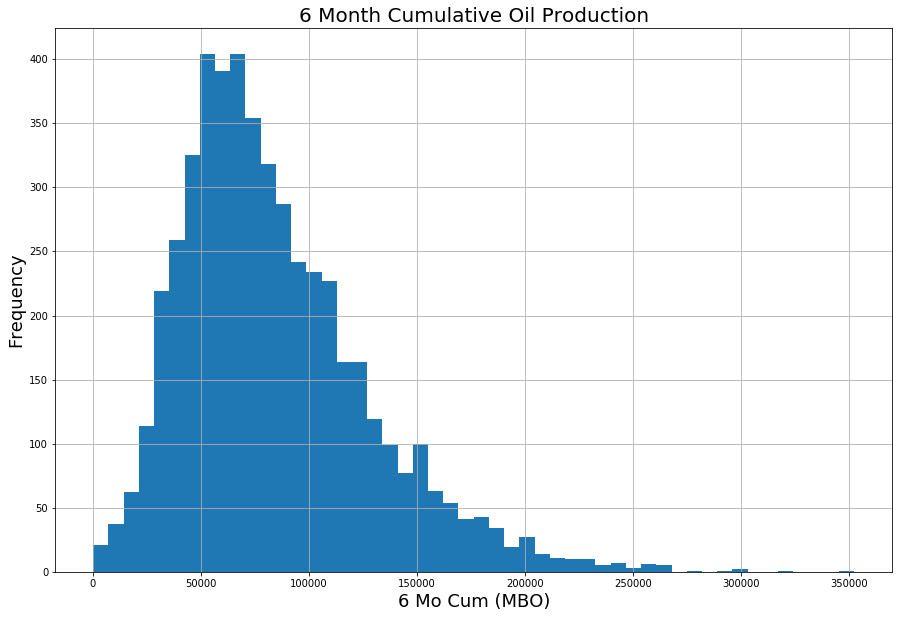

In [219]:
egfd['6mo_oil'].hist(bins=50,figsize=(15,10))
plt.title('6 Month Cumulative Oil Production',size=20)
plt.xlabel('6 Mo Cum (MBO)',size=18)
plt.ylabel('Frequency',size=18)

There is some amount of skewness associated with 6 month oil cum, but it is more normal than I anticipated. I'll check the exact amount

In [9]:
print("Skewness: %f" % egfd['6mo_oil'].skew())
print("Kurtosis: %f" % egfd['6mo_oil'].kurt())

Skewness: 1.084489
Kurtosis: 1.693244


Frankly, this data looks more normal than I anticipated which is good. 

In [10]:
pd.options.display.max_rows=100
pd.options.display.max_columns=100


Converting spud date (What is the date that each well was drilled) to check and see if we have improved in performance over time.

In [11]:
egfd['spud_date']=pd.to_datetime(egfd.spud_date)

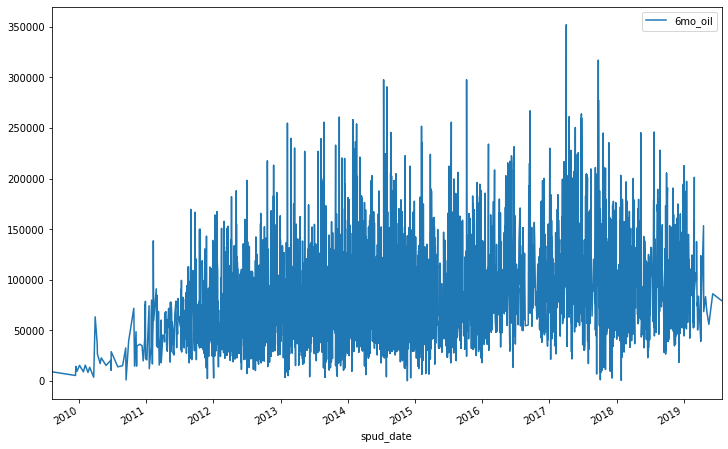

In [12]:
egfd.plot(x='spud_date',y='6mo_oil',figsize=(12,8))

Yikes....Maybe we got a tad bit better, but in general performance has been relatively stagnant. Don't tell the boss.....

I'm now going to do some column adjustment to make the dataset a bit more manageable for modeling. Things like API (a unique identifier number) and surface locations aren't really important drivers of well performance. I'm also going to convert the fluid and proppant pumped into per foot values. This should elminate collinearity between fluid/proppant and lateral length (calculated LL). 

In [13]:
egfd['prop/ft']=egfd['total_prop']/egfd['calculated_LL']
egfd['fluid/ft']=egfd['total_fluid_pumped']/egfd['calculated_LL']

In [14]:
egfd=egfd.drop(['6mo_time','api', 'reported_fluid_type', 'lease_name', 'well_num', '1_mo_oil', '1_mo_gas', '2_mo_oil', 
                      '2_mo_gas', 'cum_oil_x', 'cum_gas', 'formation', 'operator', 'td', 
                     'elevation', 'spud_date', 'surf_lat', 'surf_long',  'total_prop', 
                      'total_fluid_pumped'],axis=1)
egfd.head()

,6mo_oil,top_d,btm_d,basin,tvd,btm_lat,btm_long,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil,prop/ft,fluid/ft
0,75763,11511,15738,KARNES FAULT ZONE (GULF COAST BASIN),11554,29.046511,-97.740030,1104.194556,5357.892850,967.904791,77520,268640,1196.739125,16.033169
1,64350,11470,15624,KARNES FAULT ZONE (GULF COAST BASIN),11469,29.049162,-97.740164,1204.283785,4594.270346,967.904791,77520,268640,1376.932467,19.647951
2,120351,12019,18918,KARNES FAULT ZONE (GULF COAST BASIN),11215,29.069781,-97.736000,649.298597,7198.096133,81.229467,77520,268640,3089.705887,63.549721
3,149589,12079,17616,KARNES FAULT ZONE (GULF COAST BASIN),11087,29.062969,-97.750458,887.715736,6727.843014,664.009203,77520,268640,2626.993520,52.378898
4,110928,11710,18186,KARNES FAULT ZONE (GULF COAST BASIN),10993,29.064789,-97.750408,1072.904483,7157.680515,18.262071,77520,268640,2955.426685,59.657035


Are the basins possibly an indicator of well performance?

Karnes Mean: 86254.80899357602
Rio Mean: 55624.95145631068


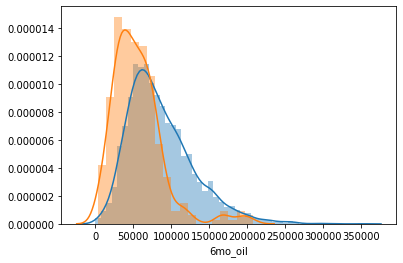

In [15]:
egfd_karnes=egfd[egfd.basin=='KARNES FAULT ZONE (GULF COAST BASIN)']
egfd_rio=egfd[egfd.basin!='KARNES FAULT ZONE (GULF COAST BASIN)']
sns.distplot(egfd_karnes['6mo_oil'])
sns.distplot(egfd_rio['6mo_oil'])
print('Karnes Mean:',egfd_karnes['6mo_oil'].mean())
print('Rio Mean:',egfd_rio['6mo_oil'].mean())

It does look like the Karnes Fault zone has slightly stronger well performance than the Rio basin. I'll map these to variables to use as possible features.

In [16]:
egfd['basin']=egfd.basin.map({'KARNES FAULT ZONE (GULF COAST BASIN)':1, 'RIO GRANDE EMBAYMENT (GULF COAST BASIN)':0})
egfd.head()

,6mo_oil,top_d,btm_d,basin,tvd,btm_lat,btm_long,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil,prop/ft,fluid/ft
0,75763,11511,15738,1,11554,29.046511,-97.740030,1104.194556,5357.892850,967.904791,77520,268640,1196.739125,16.033169
1,64350,11470,15624,1,11469,29.049162,-97.740164,1204.283785,4594.270346,967.904791,77520,268640,1376.932467,19.647951
2,120351,12019,18918,1,11215,29.069781,-97.736000,649.298597,7198.096133,81.229467,77520,268640,3089.705887,63.549721
3,149589,12079,17616,1,11087,29.062969,-97.750458,887.715736,6727.843014,664.009203,77520,268640,2626.993520,52.378898
4,110928,11710,18186,1,10993,29.064789,-97.750408,1072.904483,7157.680515,18.262071,77520,268640,2955.426685,59.657035


In [17]:
egfd.basin.value_counts()

1    4670
0     309
Name: basin, dtype: int64

I'm now going to convert bottom hole lat and longs to a geohash to use as a feature. Wells located in similar geology should be located near one another. This is similar to grouping things by zip code. The purpose of using parent well 6 month cum is also to as a proxy for geologic performance, although parent well completion can play a part in that. I can decide whether they are redundant as I investigate the model performance.

In [18]:
import pygeohash as gh
egfd['locationgeohash']=egfd.apply(lambda x: gh.encode(x.btm_lat,x.btm_long,precision=4),axis=1)
egfd.locationgeohash.value_counts()

9v4t    902
9v4k    825
9v4w    516
9v1f    474
9v4m    396
9v47    393
9v45    314
9v44    283
9v1c    209
9v4y    180
9v4s    152
9v4z    148
9v1g     89
9v4h     43
9v6b     19
9v1d     19
9v4x     10
9v1e      7
Name: locationgeohash, dtype: int64

I now need to create some dummy variables to use these in a model.

In [19]:
egfd_dummies=pd.get_dummies(egfd['locationgeohash'],prefix='location')
egfd_dummies.drop('location_9v1e',axis=1,inplace=True)
egfd=pd.merge(egfd,egfd_dummies,left_index=True,right_index=True)
egfd.head()

,6mo_oil,top_d,btm_d,basin,tvd,btm_lat,btm_long,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil,prop/ft,fluid/ft,locationgeohash,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
0,75763,11511,15738,1,11554,29.046511,-97.740030,1104.194556,5357.892850,967.904791,77520,268640,1196.739125,16.033169,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,64350,11470,15624,1,11469,29.049162,-97.740164,1204.283785,4594.270346,967.904791,77520,268640,1376.932467,19.647951,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,120351,12019,18918,1,11215,29.069781,-97.736000,649.298597,7198.096133,81.229467,77520,268640,3089.705887,63.549721,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,149589,12079,17616,1,11087,29.062969,-97.750458,887.715736,6727.843014,664.009203,77520,268640,2626.993520,52.378898,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,110928,11710,18186,1,10993,29.064789,-97.750408,1072.904483,7157.680515,18.262071,77520,268640,2955.426685,59.657035,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


I'm going to now compare each of these features to look for additional collinearity and to see which may have the largest impact on the well's performance.

In [20]:
egfd_corr=egfd.corr()
egfd_corr

,6mo_oil,top_d,btm_d,basin,tvd,btm_lat,btm_long,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil,prop/ft,fluid/ft,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
6mo_oil,1.000000,0.304491,0.350115,0.169171,0.370585,0.323905,0.383033,0.051197,0.117506,-0.184949,0.516552,0.501077,0.395040,0.393936,-0.163655,-0.057830,-0.185951,-0.074587,-0.097502,-0.129208,-0.101528,-0.054309,0.037532,0.014895,0.035942,0.355499,0.076667,-0.042939,0.088562,-0.046140,-0.043914
top_d,0.304491,1.000000,0.556979,-0.075286,0.848900,0.182773,0.429396,0.608806,-0.278387,-0.134800,0.356739,0.342565,-0.048116,-0.052452,-0.038967,-0.118658,-0.332935,-0.253926,0.017391,-0.102739,0.141603,-0.070322,0.126828,-0.234349,0.245349,0.317029,-0.021948,-0.090437,0.070169,-0.033068,-0.084576
btm_d,0.350115,0.556979,1.000000,-0.068066,0.394079,-0.122037,0.008428,0.378571,0.579938,-0.113940,0.207989,0.234783,-0.005775,0.007124,0.005372,-0.081415,-0.052495,0.036882,0.078124,-0.024150,0.127319,-0.048035,0.057503,-0.243111,0.150945,0.106921,-0.095806,-0.063207,0.001399,-0.084353,-0.044372
basin,0.169171,-0.075286,-0.068066,1.000000,-0.056260,0.403881,0.310389,-0.271393,-0.028588,-0.120280,0.145718,0.146696,0.183636,0.144728,-0.481659,0.015921,0.043728,0.034703,-0.486950,0.022216,0.075301,0.024009,0.114634,0.075612,0.045646,0.120991,0.087465,0.011539,0.049817,0.045023,0.015921
tvd,0.370585,0.848900,0.394079,-0.056260,1.000000,0.242761,0.515274,0.652527,-0.308623,-0.189282,0.391122,0.396399,-0.004237,-0.015342,-0.058476,-0.130654,-0.383808,-0.286500,0.006421,-0.137061,0.154758,-0.073333,0.125524,-0.238150,0.281703,0.365705,-0.006914,-0.097990,0.094605,-0.032914,-0.087276
btm_lat,0.323905,0.182773,-0.122037,0.403881,0.242761,1.000000,0.947026,-0.076035,-0.285192,-0.063809,0.325300,0.279010,0.232165,0.206640,-0.399794,-0.080556,-0.448955,-0.118425,-0.298499,-0.216780,-0.155027,-0.024391,-0.029775,0.147235,0.026489,0.308828,0.413918,0.075036,0.274893,0.334475,0.157043
btm_long,0.383033,0.429396,0.008428,0.310389,0.515274,0.947026,1.000000,0.153637,-0.359553,-0.113324,0.400908,0.358500,0.193242,0.165059,-0.365774,-0.133773,-0.541634,-0.221179,-0.231167,-0.212354,-0.055439,-0.048123,0.009517,0.066780,0.101165,0.364044,0.372491,0.049176,0.267221,0.271553,0.105803
initial_GOR,0.051197,0.608806,0.378571,-0.271393,0.652527,-0.076035,0.153637,1.000000,-0.116704,-0.054281,0.141881,0.130936,-0.141283,-0.155230,0.131050,-0.057973,-0.236312,-0.116579,0.070568,-0.115917,0.323207,-0.055056,-0.025823,-0.177791,0.273401,0.147633,-0.102440,-0.038778,-0.012521,-0.086426,-0.051634
calculated_LL,0.117506,-0.278387,0.579938,-0.028588,-0.308623,-0.285192,-0.359553,-0.116704,1.000000,0.023091,-0.101368,-0.047327,-0.032285,0.003131,0.048690,0.009529,0.236400,0.274434,0.080344,0.052111,0.001782,0.024819,-0.064471,-0.082947,-0.052167,-0.135543,-0.098838,0.010782,-0.047545,-0.045316,0.032532
offset_dist,-0.184949,-0.134800,-0.113940,-0.120280,-0.189282,-0.063809,-0.113324,-0.054281,0.023091,1.000000,-0.210178,-0.191493,-0.182633,-0.179186,0.155927,0.031504,0.082059,0.041537,0.044779,-0.009656,-0.066414,0.073364,-0.087997,-0.037379,0.015918,-0.122354,-0.039694,0.081964,0.054596,0.148039,0.016360


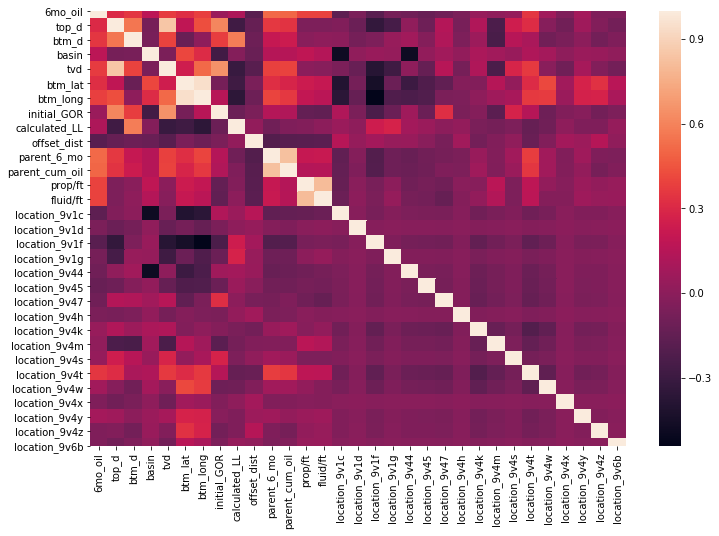

In [21]:
plt.subplots(figsize=(12,8))
sns.heatmap(egfd_corr);

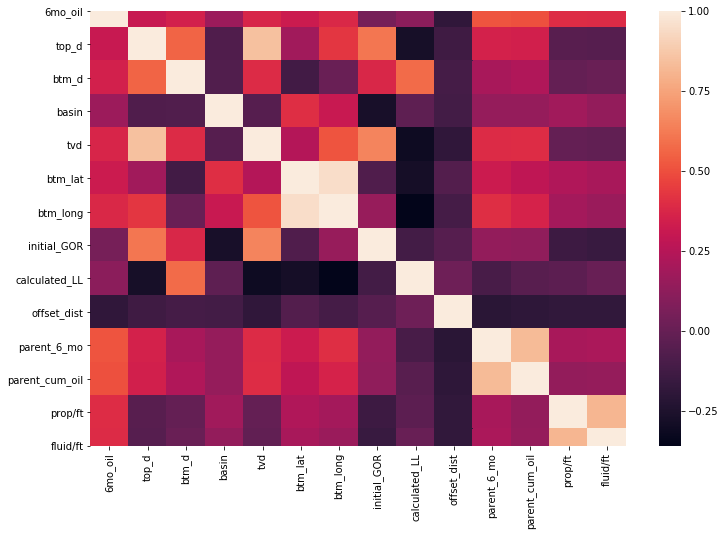

In [195]:
egfd_corr=egfd.drop(['locationgeohash',
       'location_9v1c', 'location_9v1d', 'location_9v1f', 'location_9v1g',
       'location_9v44', 'location_9v45', 'location_9v47', 'location_9v4h',
       'location_9v4k', 'location_9v4m', 'location_9v4s', 'location_9v4t',
       'location_9v4w', 'location_9v4x', 'location_9v4y', 'location_9v4z','location_9v6b'],axis=1).corr()
plt.subplots(figsize=(12,8))
sns.heatmap(egfd_corr);

As I suspected, fluid/ft and proppant/ft are very strongly correlated to one another, as are parent cum and parent 6 month cum. I'm either going to have to use PCA to deal with them or drop them from the dataset. My original premise was that parent cum would be negatively related to well performance (the more the parent had produced, the less there is remaining for the child well) but the Eagleford doesn't seem to follow that convention. Parent Cumulative production does seem to be a good geologic indicator of performance.

Dropping the bottom hole locations (lat long) so that I don't have to worry about them anymore.

In [22]:
egfd_model=egfd.drop(['btm_lat','btm_long'],axis=1)
egfd_model.head()

,6mo_oil,top_d,btm_d,basin,tvd,initial_GOR,calculated_LL,offset_dist,parent_6_mo,parent_cum_oil,prop/ft,fluid/ft,locationgeohash,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
0,75763,11511,15738,1,11554,1104.194556,5357.892850,967.904791,77520,268640,1196.739125,16.033169,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,64350,11470,15624,1,11469,1204.283785,4594.270346,967.904791,77520,268640,1376.932467,19.647951,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,120351,12019,18918,1,11215,649.298597,7198.096133,81.229467,77520,268640,3089.705887,63.549721,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,149589,12079,17616,1,11087,887.715736,6727.843014,664.009203,77520,268640,2626.993520,52.378898,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,110928,11710,18186,1,10993,1072.904483,7157.680515,18.262071,77520,268640,2955.426685,59.657035,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


What is the value of RMSE if I just use the mean to predict 6_mo Oil cumulative volume?

In [23]:

from sklearn.metrics import mean_squared_error

In [24]:
mean_data=egfd_model
mean_data['mean_pred']=egfd_model['6mo_oil'].mean()
print('RMSE of Mean Prediction:',np.sqrt(mean_squared_error(egfd_model['6mo_oil'], mean_data['mean_pred'])))

RMSE of Mean Prediction: 43683.2236738396


In [25]:
egfd_model.drop('mean_pred',axis=1,inplace=True)

So just predicting with the mean results in an RMSE of 43 MBO (43 thousand barrels), which is about an entire standard deviation.

How predictive is a simple linear regression?

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','locationgeohash'],axis=1)
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 29888.612689293997
Test Dataset RMSE: 30809.54831996197
Test R2: 0.5186924551733755


This clearly didn't perform great. I'll go ahead and drop some of the multicollinear features.I'm going to keep fluid/ft to use it interchangeably with proppant. Parent cum oil I will drop. 

In [27]:
egfd_model.drop(['parent_cum_oil'],axis=1,inplace=True)
egfd_model.columns

Index(['6mo_oil', 'top_d', 'btm_d', 'basin', 'tvd', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'prop/ft', 'fluid/ft',
       'locationgeohash', 'location_9v1c', 'location_9v1d', 'location_9v1f',
       'location_9v1g', 'location_9v44', 'location_9v45', 'location_9v47',
       'location_9v4h', 'location_9v4k', 'location_9v4m', 'location_9v4s',
       'location_9v4t', 'location_9v4w', 'location_9v4x', 'location_9v4y',
       'location_9v4z', 'location_9v6b'],
      dtype='object')

How will that affect performance?

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','locationgeohash','fluid/ft'],axis=1)
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 30197.713764811157
Test Dataset RMSE: 31370.815450441183
Test R2: 0.5009964647532072


What if I use fluid instead of proppant?

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','locationgeohash','prop/ft','y_pred'],axis=1)
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 29944.276856165594
Test Dataset RMSE: 30801.396792427422
Test R2: 0.4903695408072744


I'm going to attempt a very basic linear regression with only the strongest drivers (according to the correlation matrix)

In [177]:
egfd_model.columns

Index(['6mo_oil', 'top_d', 'btm_d', 'basin', 'tvd', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'prop/ft', 'fluid/ft',
       'locationgeohash', 'location_9v1c', 'location_9v1d', 'location_9v1f',
       'location_9v1g', 'location_9v44', 'location_9v45', 'location_9v47',
       'location_9v4h', 'location_9v4k', 'location_9v4m', 'location_9v4s',
       'location_9v4t', 'location_9v4w', 'location_9v4x', 'location_9v4y',
       'location_9v4z', 'location_9v6b', 'y_pred'],
      dtype='object')

In [181]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr=LinearRegression()
feature_cols=['btm_d', 'tvd', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo','fluid/ft']
X=egfd_model[feature_cols]
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 31105.892406367973
Test Dataset RMSE: 31566.187298104076
Test R2: 0.46474736759341195


Given that there can be a wide range in values across features, I'll try scaling the data to see if that impacts model performance. I'll try Min Max Scaling first

In [30]:
egfd_model.columns

Index(['6mo_oil', 'top_d', 'btm_d', 'basin', 'tvd', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'prop/ft', 'fluid/ft',
       'locationgeohash', 'location_9v1c', 'location_9v1d', 'location_9v1f',
       'location_9v1g', 'location_9v44', 'location_9v45', 'location_9v47',
       'location_9v4h', 'location_9v4k', 'location_9v4m', 'location_9v4s',
       'location_9v4t', 'location_9v4w', 'location_9v4x', 'location_9v4y',
       'location_9v4z', 'location_9v6b'],
      dtype='object')

In [31]:
cols=['6mo_oil', 'top_d', 'btm_d', 'basin', 'tvd', 'initial_GOR',
       'calculated_LL', 'offset_dist', 'parent_6_mo', 'fluid/ft',
       'location_9v1c', 'location_9v1d', 'location_9v1f',
       'location_9v1g', 'location_9v44', 'location_9v45', 'location_9v47',
       'location_9v4h', 'location_9v4k', 'location_9v4m', 'location_9v4s',
       'location_9v4t', 'location_9v4w', 'location_9v4x', 'location_9v4y',
       'location_9v4z', 'location_9v6b']


In [32]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
egfd_scale=egfd_model.drop(['locationgeohash','prop/ft'],axis=1)
egfd_scale=mm_scaler.fit_transform(egfd_scale)
egfd_scale=pd.DataFrame(egfd_scale)
egfd_scale

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.214429,0.663879,0.685513,1.0,0.840413,0.137972,0.318599,0.388211,0.275538,0.152718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.181996,0.661515,0.680547,1.0,0.834230,0.150490,0.258434,0.388211,0.275538,0.187149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.341137,0.693177,0.824026,1.0,0.815755,0.081081,0.463586,0.032236,0.275538,0.605318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.424224,0.696638,0.767314,1.0,0.806445,0.110898,0.426536,0.266206,0.275538,0.498915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.314359,0.675356,0.792142,1.0,0.799607,0.134059,0.460402,0.006956,0.275538,0.568240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4974,0.171397,0.611454,0.708206,1.0,0.748691,0.069629,0.378141,0.137265,0.268277,0.327481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4975,0.245506,0.613242,0.709861,1.0,0.745199,0.051571,0.377949,0.151638,0.268277,0.297572,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4976,0.232227,0.615549,0.718486,1.0,0.748763,0.069465,0.381898,0.137662,0.268277,0.214692,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4977,0.275865,0.613588,0.717441,1.0,0.746509,0.058862,0.388990,0.137662,0.268277,0.213936,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


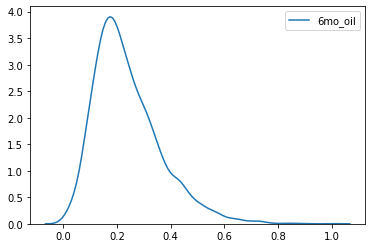

In [33]:

egfd_scale.columns=cols
sns.kdeplot(egfd_scale['6mo_oil'])

In [35]:
X=egfd_scale.drop(['6mo_oil'],axis=1)
y=egfd_scale['6mo_oil']
#linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
#print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
#print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Test R2: 0.5099317685517836


No marked improvement with Min Max Scaling. I'll try StandardScaler

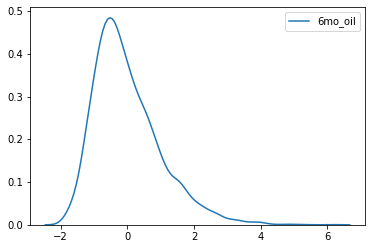

In [36]:
from sklearn import preprocessing

s_scaler=preprocessing.StandardScaler()
egfd_scale=egfd_model.drop(['locationgeohash','prop/ft'],axis=1)
egfd_scale=s_scaler.fit_transform(egfd_scale)
egfd_scale=pd.DataFrame(egfd_scale)
egfd_scale.columns=cols
sns.kdeplot(egfd_scale['6mo_oil'])

In [37]:
X=egfd_scale.drop(['6mo_oil'],axis=1)
y=egfd_scale['6mo_oil']
#linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
lrstandscale=LinearRegression()
lrstandscale.fit(X_train,y_train)
y_pred_test=lrstandscale.predict(X_test)
y_pred=lrstandscale.predict(X)
#print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
#print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lrstandscale.score(X_test,y_test))

Test R2: 0.5099317685517836


I'm going to plot the coefficients (since they are normalized). That should tell me truly how impactful things are

In [38]:
data_tuple=list(zip(X.columns,lrstandscale.coef_))
coef_df=pd.DataFrame(data_tuple,columns=['Feature','Coef'])
coef_df.sort_values(by='Coef')

,Feature,Coef
4,initial_GOR,-0.194239
0,top_d,-0.130186
15,location_9v47,-0.097343
11,location_9v1f,-0.095321
14,location_9v45,-0.092791
9,location_9v1c,-0.082732
13,location_9v44,-0.082613
17,location_9v4k,-0.075902
19,location_9v4s,-0.058902
24,location_9v4z,-0.053613


I'm really suprised that TVD has such a large affect on the performance of this model. Lower Eagleford Wells are generally better, but without knowing more about this dataset it is tough for me to think of why this might be happening. I'll look at TVD really quickly.

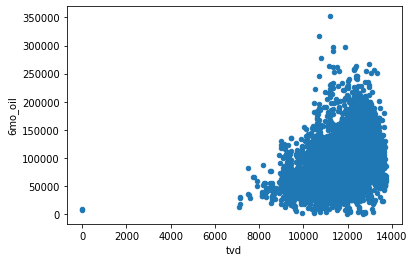

In [39]:
egfd_model.plot(kind='scatter',x='tvd',y='6mo_oil')

I probably need to drop the data point at 0 as that doesn't make any sense....

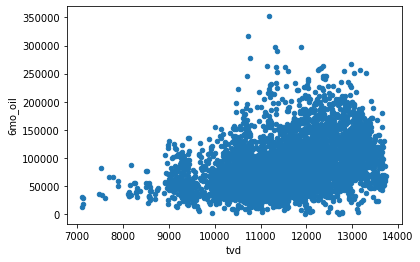

In [40]:
egfd_model=egfd_model[egfd_model.tvd>1]
egfd_model.plot(kind='scatter',x='tvd',y='6mo_oil')

In [41]:
egfd_model.describe()

,6mo_oil,top_d,btm_d,basin,tvd,initial_GOR,calculated_LL,offset_dist,parent_6_mo,prop/ft,fluid/ft,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
count,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.00000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000,4977.000000
mean,84384.453285,11763.225839,17161.683946,0.937914,11556.176211,1821.325626,5802.153572,469.916710,81138.342174,1495.587378,28.434371,0.041993,0.003818,0.095238,0.017882,0.056862,0.06309,0.078963,0.008640,0.165562,0.079566,0.030540,0.181033,0.103677,0.002009,0.036166,0.029737,0.003818
std,43669.775306,1234.757077,1708.152454,0.241335,1106.842151,1659.832188,1415.161867,344.382150,44111.675255,737.676949,15.643250,0.200594,0.061675,0.293573,0.132537,0.231601,0.24315,0.269708,0.092557,0.371724,0.270647,0.172086,0.385084,0.304872,0.044784,0.186723,0.169877,0.061675
min,306.000000,0.000000,0.000000,0.000000,7106.000000,0.986193,1314.179737,0.935850,1103.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53257.000000,11005.000000,16093.000000,1.000000,10786.000000,736.808939,4935.663590,266.557744,51267.000000,907.426338,17.046876,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75694.000000,11825.000000,17149.000000,1.000000,11604.000000,1149.578235,5686.652506,375.022810,75656.000000,1303.735055,23.792429,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,107928.000000,12664.000000,18224.000000,1.000000,12363.000000,2265.893433,6487.350365,550.835894,105744.000000,2012.160183,38.474235,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,352203.000000,17339.000000,22958.000000,1.000000,13748.000000,7996.873437,14006.347420,2491.766447,278440.000000,4949.274225,104.985684,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


crud....I need to drop some other zeros

In [42]:
egfd_model=egfd_model[egfd_model['prop/ft']>1]
egfd_model=egfd_model[egfd_model['top_d']>1]
egfd_model=egfd_model[egfd_model['btm_d']>1]
egfd_model.describe()

,6mo_oil,top_d,btm_d,basin,tvd,initial_GOR,calculated_LL,offset_dist,parent_6_mo,prop/ft,fluid/ft,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
count,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.00000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000
mean,84314.997778,11782.937576,17188.828081,0.938384,11555.500808,1821.142848,5800.568202,470.980890,81205.012929,1499.542839,28.374298,0.041616,0.003838,0.095354,0.017980,0.056566,0.063434,0.079192,0.008687,0.166465,0.07899,0.030707,0.179394,0.104242,0.002020,0.036364,0.029899,0.003838
std,43572.360868,1142.548876,1562.706074,0.240481,1107.056544,1659.727388,1415.029976,344.780245,44051.602740,731.949342,15.600790,0.199731,0.061842,0.293732,0.132891,0.231034,0.243767,0.270065,0.092807,0.372535,0.26975,0.172540,0.383721,0.305606,0.044906,0.187212,0.170326,0.061842
min,306.000000,7110.000000,11722.000000,0.000000,7106.000000,0.986193,1314.179737,0.935850,1103.000000,22.923430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53259.250000,11008.250000,16096.250000,1.000000,10785.250000,736.752970,4935.148542,267.510321,51267.000000,911.409361,17.036642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75692.500000,11831.000000,17153.500000,1.000000,11605.000000,1149.266375,5686.045920,375.334386,75754.500000,1304.524370,23.740059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,107893.750000,12671.000000,18225.000000,1.000000,12360.750000,2269.985571,6486.835474,552.413679,105892.000000,2011.928717,38.352171,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,352203.000000,17339.000000,22958.000000,1.000000,13748.000000,7996.873437,14006.347420,2491.766447,278440.000000,4949.274225,104.985684,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


How will this affect my model?

In [44]:
#dropping the geohash location

lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','prop/ft','locationgeohash'],axis=1)
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 29944.276856165594
Test Dataset RMSE: 30801.396792427422
Test R2: 0.4903695408072744


I'm going to drop a few more features just to see what happens.

In [45]:

lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','prop/ft','locationgeohash','btm_d','top_d','basin'],axis=1)
y=egfd_model['6mo_oil']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred_test=lr.predict(X_test)
y_pred=lr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lr.score(X_test,y_test))

Total Dataset RMSE: 30197.87473753661
Test Dataset RMSE: 30994.822494098782
Test R2: 0.48394871866139344


Attempting the Scaling Excersize again

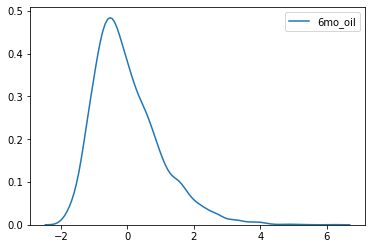

In [46]:


s_scaler=preprocessing.StandardScaler()
egfd_scale=egfd_model.drop(['locationgeohash','prop/ft'],axis=1)
egfd_scale=s_scaler.fit_transform(egfd_scale)
egfd_scale=pd.DataFrame(egfd_scale)
egfd_scale.columns=cols
sns.kdeplot(egfd_scale['6mo_oil'])

In [47]:
X=egfd_scale.drop(['6mo_oil'],axis=1)
y=egfd_scale['6mo_oil']
#linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
lrstandscale=LinearRegression()
lrstandscale.fit(X_train,y_train)
y_pred_test=lrstandscale.predict(X_test)
y_pred=lrstandscale.predict(X)
#print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
#print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lrstandscale.score(X_test,y_test))

Test R2: 0.49036954080727607


In [48]:
data_tuple=list(zip(X.columns,lrstandscale.coef_))
coef_df=pd.DataFrame(data_tuple,columns=['Feature','Coef'])
coef_df.sort_values(by='Coef')

,Feature,Coef
17,location_9v4k,-0.223203
11,location_9v1f,-0.212201
15,location_9v47,-0.211476
4,initial_GOR,-0.204378
14,location_9v45,-0.180882
13,location_9v44,-0.163662
9,location_9v1c,-0.137113
19,location_9v4s,-0.130392
24,location_9v4z,-0.114534
20,location_9v4t,-0.111434


Just Curious what a k folds excersize would look like. 

In [50]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
kf = model_selection.KFold(n_splits=10, shuffle=True)
lr=LinearRegression()
X=egfd_model.drop(['6mo_oil','prop/ft','locationgeohash'],axis=1)
y=egfd_model['6mo_oil']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
k_predictions=cross_val_predict(lr,X,y,cv=10)


[Text(0, 0.5, 'Prediction'), Text(0.5, 0, 'Actuals')]

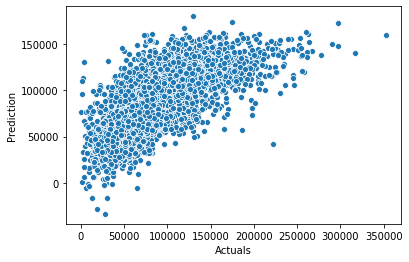

In [51]:
plot_k=sns.scatterplot(y,k_predictions)
plot_k.set(xlabel='Actuals',ylabel='Prediction')

In [52]:
from sklearn.model_selection import cross_val_score
kfold_scores=cross_val_score(lr,X,y,cv=10,scoring='neg_mean_squared_error')
kfold_scores.mean()

-932950984.9767301

I don't totally understand what I was trying to accomplish...Especially without a good model built. I'll come back to this. For now, I'm going to move on to a basic decision tree model.

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

X=egfd_model.drop(['6mo_oil','prop/ft','locationgeohash'],axis=1)
y=egfd_model['6mo_oil']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
treereg=DecisionTreeRegressor(random_state=123,max_depth=15)
treereg.fit(X_train,y_train)
y_pred_test=treereg.predict(X_test)
y_pred=treereg.predict(X)

In [54]:
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',lrstandscale.score(X_test,y_test))

Total Dataset RMSE: 19501.212852696215
Test Dataset RMSE: 36738.68816547299
Test R2: -1.541321202282799


Well this is frustrating. I suppose I'll look at the max tree depth.

In [55]:
max_depth_range = list(range(1, 25))
accuracy_score=[]
RMSE_score=[]
for depth in max_depth_range:
    treereg=DecisionTreeRegressor(max_depth=depth,random_state=123)
    r2score=cross_val_score(treereg,X,y,cv=10)
    rmsescore=cross_val_score(treereg,X,y,cv=10,scoring='neg_mean_squared_error')
    accuracy_score.append(np.mean(r2score))
    RMSE_score.append(np.mean(np.sqrt(-rmsescore)))

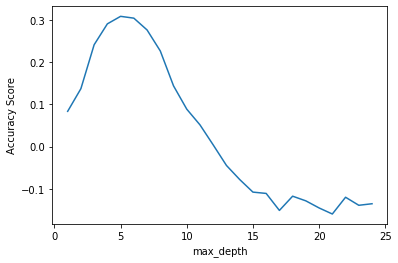

In [56]:
plt.plot(max_depth_range, accuracy_score);
plt.xlabel('max_depth');
plt.ylabel('Accuracy Score');

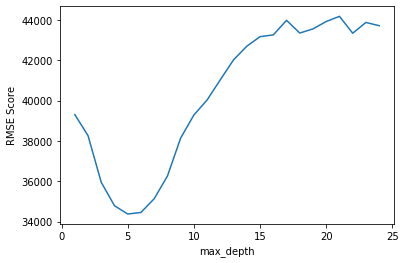

In [57]:
plt.plot(max_depth_range, RMSE_score);
plt.xlabel('max_depth');
plt.ylabel('RMSE Score');

So a decision tree by itself didn't work out very well. I'm going to attempt more complex models to see if they improve.

In [58]:
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=123)

In [59]:
bagreg.fit(X_train,y_train)
y_pred_test=bagreg.predict(X_test)
y_pred=bagreg.predict(X)

In [60]:
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',bagreg.score(X_test,y_test))

Total Dataset RMSE: 16064.447688928954
Test Dataset RMSE: 27548.31830388712
Test R2: 0.5923337688031082


Some slight improvement here! That is a start I suppose.... I'll tweak the n_estimators

In [61]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=1000, bootstrap=True, oob_score=True, random_state=123)
bagreg.fit(X_train,y_train)
y_pred_test=bagreg.predict(X_test)
y_pred=bagreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',bagreg.score(X_test,y_test))

Total Dataset RMSE: 16067.170754159446
Test Dataset RMSE: 27554.09520547393
Test R2: 0.5921627750894825


No change in the result with double the n_estimators. I'll change other hyperparameters

In [62]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, max_samples=.9,bootstrap=True, oob_score=True, random_state=123)
bagreg.fit(X_train,y_train)
y_pred_test=bagreg.predict(X_test)
y_pred=bagreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',bagreg.score(X_test,y_test))

Total Dataset RMSE: 16594.113222579756
Test Dataset RMSE: 27655.0052241384
Test R2: 0.5891701003968834


I'm going to attempt a bagging regressor with the trimmed down features noted above.

In [64]:
X.columns

Index(['top_d', 'btm_d', 'basin', 'tvd', 'initial_GOR', 'calculated_LL',
       'offset_dist', 'parent_6_mo', 'fluid/ft', 'location_9v1c',
       'location_9v1d', 'location_9v1f', 'location_9v1g', 'location_9v44',
       'location_9v45', 'location_9v47', 'location_9v4h', 'location_9v4k',
       'location_9v4m', 'location_9v4s', 'location_9v4t', 'location_9v4w',
       'location_9v4x', 'location_9v4y', 'location_9v4z', 'location_9v6b'],
      dtype='object')

In [65]:
feature_cols=[ 'btm_d', 'tvd', 'initial_GOR', 'calculated_LL',
       'offset_dist', 'parent_6_mo', 'fluid/ft', 'location_9v1c',
       'location_9v1d', 'location_9v1f', 'location_9v1g', 'location_9v44',
       'location_9v45', 'location_9v47', 'location_9v4h', 'location_9v4k',
       'location_9v4m', 'location_9v4s', 'location_9v4t', 'location_9v4w',
       'location_9v4x', 'location_9v4y', 'location_9v4z', 'location_9v6b']
X=egfd_model[feature_cols]
y=egfd_model['6mo_oil']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [66]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
bagreg.fit(X_train,y_train)
y_pred_test=bagreg.predict(X_test)
y_pred=bagreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',bagreg.score(X_test,y_test))

Total Dataset RMSE: 16174.991668382196
Test Dataset RMSE: 27784.93254408695
Test R2: 0.5853007526006448


Random Forest Regression

In [67]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor(n_estimators=1000, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)
y_pred_test=rfreg.predict(X_test)
y_pred=rfreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',rfreg.score(X_test,y_test))

Total Dataset RMSE: 15912.078319717997
Test Dataset RMSE: 27268.395061521387
Test R2: 0.6005764121138707


Heyo! I broke the .6 mark..... Not the best, but not the worst! I'll try to tune the number of features

In [68]:
rfreg = RandomForestRegressor(n_estimators=1000, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)
y_pred_test=rfreg.predict(X_test)
y_pred=rfreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',rfreg.score(X_test,y_test))

Total Dataset RMSE: 15878.306616009071
Test Dataset RMSE: 27204.38374858171
Test R2: 0.6024494683609862


In [69]:
rfreg = RandomForestRegressor(n_estimators=1000, max_features=6, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)
y_pred_test=rfreg.predict(X_test)
y_pred=rfreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',rfreg.score(X_test,y_test))

Total Dataset RMSE: 15863.710258966188
Test Dataset RMSE: 27207.06659878059
Test R2: 0.6023710529758541


In [70]:
rfreg = RandomForestRegressor(n_estimators=4000, max_features=3, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)
y_pred_test=rfreg.predict(X_test)
y_pred=rfreg.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',rfreg.score(X_test,y_test))

Total Dataset RMSE: 15910.865436490041
Test Dataset RMSE: 27299.122017066617
Test R2: 0.5996757367600092


It looks like, at least with this data, using more of the features helps the model very slighlty. 

In [71]:

import xgboost as xgb
xgbr=xgb.XGBRegressor(random_state=1, n_estimators=1000)

In [82]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
xgbr.fit(X_train,y_train)
y_pred_test=xgbr.predict(X_test)
y_pred=xgbr.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',xgbr.score(X_test,y_test))

Total Dataset RMSE: 14749.261479001585
Test Dataset RMSE: 29492.430703578622
Test R2: 0.5327646544038792


Yikes....XG Boost didn't help out very much. 

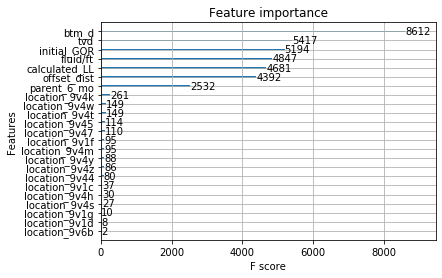

In [80]:
from xgboost import plot_importance

plot_importance(xgbr)

plt.show()

Checking out catboost. The first comparison will be a direct comparison to XG Boost. Then I will use the categorical features portion of the model.

In [83]:
from catboost import CatBoostRegressor

In [87]:
catboost=CatBoostRegressor(random_seed=1,iterations=100,learning_rate=0.1, loss_function='RMSE')
catboost.fit(X_train,y_train,eval_set=(X_test,y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 42028.2421712	test: 41596.3112060	best: 41596.3112060 (0)	total: 10.2ms	remaining: 1.01s
1:	learn: 40440.5882319	test: 40115.3818817	best: 40115.3818817 (1)	total: 14.4ms	remaining: 704ms
2:	learn: 39106.6676551	test: 38919.2525661	best: 38919.2525661 (2)	total: 18.7ms	remaining: 603ms
3:	learn: 37969.1298833	test: 37934.4730672	best: 37934.4730672 (3)	total: 21.8ms	remaining: 524ms
4:	learn: 37027.7349848	test: 37042.7747762	best: 37042.7747762 (4)	total: 25ms	remaining: 475ms
5:	learn: 36123.6639291	test: 36256.2419912	best: 36256.2419912 (5)	total: 28.7ms	remaining: 450ms
6:	learn: 35383.5098686	test: 35611.9795317	best: 35611.9795317 (6)	total: 31.9ms	remaining: 424ms
7:	learn: 34662.9596919	test: 35004.0443159	best: 35004.0443159 (7)	total: 35.3ms	remaining: 406ms
8:	learn: 34017.0632791	test: 34442.6230618	best: 34442.6230618 (8)	total: 38.5ms	remaining: 389ms
9:	learn: 33427.1802545	test: 33937.4633040	best: 33937.4633040 (9)	total: 45.3ms	remaining: 408ms
10:	learn: 3

It appears that this does well early on while iterating and then deviates from the test set. I'm not really sure why.

In [89]:
y_pred_test=catboost.predict(X_test)
y_pred=catboost.predict(X)
print('Total Dataset RMSE:',np.sqrt(mean_squared_error(y, y_pred)))
print('Test Dataset RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('Test R2:',catboost.score(X_test,y_test))

Total Dataset RMSE: 25771.693662961185
Test Dataset RMSE: 28913.04490895478
Test R2: 0.5509422300878032


In [90]:
feature_cols

['btm_d',
 'tvd',
 'initial_GOR',
 'calculated_LL',
 'offset_dist',
 'parent_6_mo',
 'fluid/ft',
 'location_9v1c',
 'location_9v1d',
 'location_9v1f',
 'location_9v1g',
 'location_9v44',
 'location_9v45',
 'location_9v47',
 'location_9v4h',
 'location_9v4k',
 'location_9v4m',
 'location_9v4s',
 'location_9v4t',
 'location_9v4w',
 'location_9v4x',
 'location_9v4y',
 'location_9v4z',
 'location_9v6b']

In [91]:
feature_cols2=['btm_d',
 'tvd',
 'initial_GOR',
 'calculated_LL',
 'offset_dist',
 'parent_6_mo',
 'fluid/ft','locationgeohash']
X=egfd_model[feature_cols2]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [95]:
categorical_features_indices = np.where(egfd_model.dtypes == np.object)[0]
categorical_features_indices

array([11], dtype=int64)

In [96]:
egfd_model.head()

,6mo_oil,top_d,btm_d,basin,tvd,initial_GOR,calculated_LL,offset_dist,parent_6_mo,prop/ft,fluid/ft,locationgeohash,location_9v1c,location_9v1d,location_9v1f,location_9v1g,location_9v44,location_9v45,location_9v47,location_9v4h,location_9v4k,location_9v4m,location_9v4s,location_9v4t,location_9v4w,location_9v4x,location_9v4y,location_9v4z,location_9v6b
0,75763,11511,15738,1,11554,1104.194556,5357.892850,967.904791,77520,1196.739125,16.033169,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,64350,11470,15624,1,11469,1204.283785,4594.270346,967.904791,77520,1376.932467,19.647951,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,120351,12019,18918,1,11215,649.298597,7198.096133,81.229467,77520,3089.705887,63.549721,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,149589,12079,17616,1,11087,887.715736,6727.843014,664.009203,77520,2626.993520,52.378898,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,110928,11710,18186,1,10993,1072.904483,7157.680515,18.262071,77520,2955.426685,59.657035,9v4m,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


For whatever reason, I can't use the categorical feature of catboost unless the indices of that column is less than 8. I'm going to tune XG boost to see if anything improves it.

In [127]:
X=egfd_model[feature_cols]
print(X.columns)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Index(['btm_d', 'tvd', 'initial_GOR', 'calculated_LL', 'offset_dist',
       'parent_6_mo', 'fluid/ft', 'location_9v1c', 'location_9v1d',
       'location_9v1f', 'location_9v1g', 'location_9v44', 'location_9v45',
       'location_9v47', 'location_9v4h', 'location_9v4k', 'location_9v4m',
       'location_9v4s', 'location_9v4t', 'location_9v4w', 'location_9v4x',
       'location_9v4y', 'location_9v4z', 'location_9v6b'],
      dtype='object')
0        75763
1        64350
2       120351
3       149589
4       110928
         ...  
5113     60620
5114     86699
5115     82026
5116     97382
5117    104428
Name: 6mo_oil, Length: 4950, dtype: int64


In [129]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 1)
from pprint import pprint

In [132]:
pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


Following a recommended workflow from TowardsDataScience for Random Forest tuning since that has been my best performing model so far.

In [156]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(random_state = 1,bootstrap=True,max_depth=None,max_features=5,n_estimators=2000,oob_score=True)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [157]:
rf.score(X_test,y_test)

0.603265766570975

In [158]:
from sklearn.model_selection import cross_validate

In [159]:
cv=cross_validate(rf,X,y,cv=5)
cv['test_score'].mean()

0.48023694531486927

In [162]:
rf = RandomForestRegressor(random_state = 1,bootstrap=True,max_depth=50,max_features=5,n_estimators=2000,oob_score=True)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [163]:
rf.score(X_test,y_test)

0.603265766570975

In [165]:
rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=5,n_estimators=2000,oob_score=False)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [166]:
rf.score(X_test,y_test)

0.6095820073709424

In [175]:
rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=6,n_estimators=2000,oob_score=False)

kf = model_selection.KFold(n_splits=5, shuffle=True)
np.mean(cross_val_score(rf,X,y,cv=kf,scoring='r2'))

0.6566390040013118

In [173]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

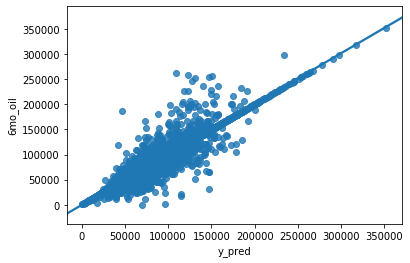

In [174]:
egfd_model['y_pred']=rf.predict(X)
sns.regplot(x='y_pred',y='6mo_oil',data=egfd_model)

Look at feature importance. I may not be able to plot this because when it fits the data, it fits it perfectly, if you fit all of the data. 

In [182]:
feature_cols=[ 'btm_d', 'tvd', 'initial_GOR', 'calculated_LL',
       'offset_dist', 'parent_6_mo', 'fluid/ft', 'location_9v1c',
       'location_9v1d', 'location_9v1f', 'location_9v1g', 'location_9v44',
       'location_9v45', 'location_9v47', 'location_9v4h', 'location_9v4k',
       'location_9v4m', 'location_9v4s', 'location_9v4t', 'location_9v4w',
       'location_9v4x', 'location_9v4y', 'location_9v4z', 'location_9v6b']
X=egfd_model[feature_cols]
y=egfd_model['6mo_oil']

rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=6,n_estimators=2000,oob_score=False)

kf = model_selection.KFold(n_splits=5, shuffle=True)
np.mean(np.sqrt(-cross_val_score(rf,X,y,cv=kf,scoring='neg_mean_squared_error')))

25479.209834467445

In [185]:
from sklearn.model_selection import cross_val_predict

In [186]:
k_predictions = cross_val_predict(rf, X, y, cv=5)

(0, 350000)

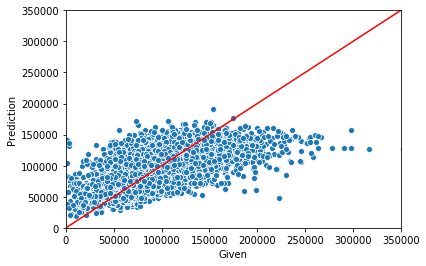

In [190]:
x_plot = np.linspace(0,350000,100)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')
plot_k = sns.scatterplot(y, k_predictions)
plot_k.set(xlabel='Given', ylabel='Prediction')
plt.xlim(0,350000)
plt.ylim(0,350000)

In [198]:
feature_cols=[ 'btm_d', 'tvd', 'initial_GOR', 'calculated_LL',
       'offset_dist', 'parent_6_mo', 'fluid/ft', 'location_9v1c',
       'location_9v1d', 'location_9v1f', 'location_9v1g', 'location_9v44',
       'location_9v45', 'location_9v47', 'location_9v4h', 'location_9v4k',
       'location_9v4m', 'location_9v4s', 'location_9v4t', 'location_9v4w',
       'location_9v4x', 'location_9v4y', 'location_9v4z', 'location_9v6b']
X=egfd_model[feature_cols]
y=egfd_model['6mo_oil']

rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=6,n_estimators=2000,oob_score=False)

kf = model_selection.KFold(n_splits=6, shuffle=True)
np.mean(cross_val_score(rf,X,y,cv=kf,scoring='r2'))

0.6571656718160762

In [199]:
from sklearn.feature_selection import SelectFromModel
rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=6,n_estimators=2000,oob_score=False)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=50,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [201]:
X_important =  SelectFromModel(rf, threshold='mean', prefit=True).transform(X_test)

In [203]:
X_important.shape

(1238, 3)

In [205]:
rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=3,n_estimators=2000,oob_score=False)
scores = cross_val_score(rf, X_important, y_test, cv=6, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

42838.3673957616

In [207]:
feature_cols=[ 'btm_d', 'tvd', 'initial_GOR', 'calculated_LL',
       'offset_dist', 'parent_6_mo', 'fluid/ft', 'location_9v1c',
       'location_9v1d', 'location_9v1f', 'location_9v1g', 'location_9v44',
       'location_9v45', 'location_9v47', 'location_9v4h', 'location_9v4k',
       'location_9v4m', 'location_9v4s', 'location_9v4t', 'location_9v4w',
       'location_9v4x', 'location_9v4y', 'location_9v4z', 'location_9v6b']
X=egfd_model[feature_cols]
y=egfd_model['6mo_oil']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
rf = RandomForestRegressor(random_state = 1,bootstrap=False,max_depth=50,max_features=6,n_estimators=2000,oob_score=False)
rf.fit(X_train, y_train)
pd.DataFrame({'feature':feature_cols, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
5,parent_6_mo,0.220055
6,fluid/ft,0.163118
0,btm_d,0.152144
1,tvd,0.120750
3,calculated_LL,0.083609
2,initial_GOR,0.081308
4,offset_dist,0.063404
18,location_9v4t,0.045681
19,location_9v4w,0.011582
16,location_9v4m,0.008919


In [208]:
importance_frame=pd.DataFrame({'feature':feature_cols, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

In [213]:
importance_frame.set_index('feature',drop=True,inplace=True)




KeyError: "None of ['feature'] are in the columns"

Text(0.5, 1.0, 'Feature Importance According to Random Forest')

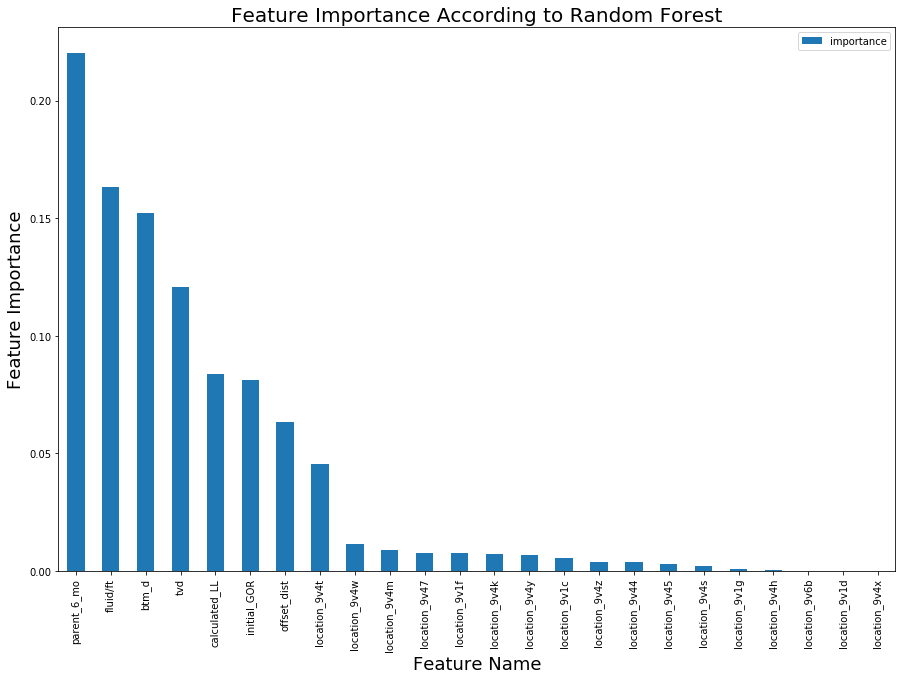

In [217]:
importance_frame.plot(kind='bar',figsize=(15,10))
plt.ylabel('Feature Importance',size=18)
plt.xlabel('Feature Name',size=18)
plt.title('Feature Importance According to Random Forest',size=20)